In [1]:
import numpy as np
from core import utils, geodesics, generative_models, manifolds
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
from sklearn.metrics import pairwise_distances
from tqdm.auto import tqdm
import gc

In [2]:
# Define the device
_device = "mps" if torch.backends.mps.is_available() else "cpu"
_device = "cuda" if torch.cuda.is_available() else _device
device = torch.device(_device)

# Shortest paths in the latent space with pullback metric

In this experiment we train a VAE and then we use the pull-back metric
such that to compute shortest paths in the latent space.

Reference "Latent Space Oddity: on the Curvature of Deep Generative Models", G. Arvanitidis, et. al., ICLR 2018


In [3]:
# Construct an artificial dataset
params = {'N': 2000, 'data_type': 2, 'sigma': 0.1, 'r': 0.2}
X_train = utils.generate_data(params)
N_train, D = X_train.shape

In [4]:
# Parameters of the VAE
d = 2  # The latent space dimension
activFunName = 'tanh'  # tanh used in the synthetics
activations_list = {
    'softplus': nn.Softplus(),
    'tanh': nn.Tanh(),
    'relu': nn.ReLU()
}
activFun = activations_list[activFunName]
H = 32
lambda_reg = 1e-7  # For the weights of the networks
epochs = 500
warmup = int(0.33 * epochs)
learning_rate = 1e-3
clipping_value = 1
batch_size = 128

In [5]:
# The model and the optimizer for the VAE
model = generative_models.VAE_model(d, D, H, activFun)
optimizer_model = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)

In [6]:
# Train the VAE with the new prior
ELBO = np.zeros((epochs, 1))
for epoch in tqdm(range(epochs), leave=True):
    # Permute the indices of the train data
    permutation = np.random.permutation(N_train)
    # Initialize the losses
    train_loss = 0
    train_loss_num = 0
    # Train for all the batches
    for i in range(0, N_train, batch_size):
        indices = permutation[i:i + batch_size]
        X_batch = torch.from_numpy(X_train[indices, :].astype(np.float32))  # batch_indices x D
        # The VAE
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)
        # Compute the regularization parameter
        if warmup == 0:
            r = 0
        else:
            r = 1. * epoch / warmup
            if r > 1.:
                r = 1.
        # The VAE loss
        loss = generative_models.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                          mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)
        optimizer_model.zero_grad()
        loss.backward()
        optimizer_model.step()
        train_loss += loss.item()
        train_loss_num += 1

    ELBO[epoch] = train_loss / train_loss_num
    #if epoch % 20 == 0:
    #    print("[Epoch: {}/{}] [objective: {:.3f}]".format(epoch, epochs, ELBO[epoch, 0]))

ELBO_train = ELBO[epoch, 0].round(2)
print('[ELBO train: ' + str(ELBO_train) + ']')
del MU_X_eval, MU_Z_eval, Z_ENC_eval
del LOG_VAR_X_eval, LOG_VAR_Z_eval
print("Training finished")

  0%|          | 0/500 [00:00<?, ?it/s]

[ELBO train: -3.42]
Training finished


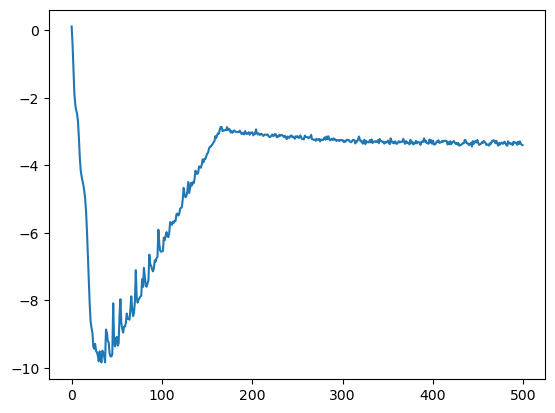

In [18]:
plt.figure()
plt.plot(ELBO)
plt.show()

In [7]:
# Encode and Decode the data
with torch.no_grad():
    model_input = torch.from_numpy(X_train.astype(np.float32))#.to(device)
    MU_X_data, LOG_VAR_X_data, _, MU_Z_data, LOG_VAR_Z_data = model.forward(model_input)
    MU_Z_data = MU_Z_data.detach().numpy()
    VAR_Z_data = np.exp(LOG_VAR_Z_data.detach().numpy())
    MU_X_data = MU_X_data.detach().numpy()
    VAR_X_data = np.exp(LOG_VAR_X_data.detach().numpy())

gc.collect()

757

In [8]:
# The RBF parameters
alpha_rbf = 1000 * np.sqrt(VAR_X_data).mean()  # USER CHOICE: the maximum std
zeta_rbf = 1 / (alpha_rbf ** 2)

K_rbf = 100  # Number of rbf centers
W_rbf = torch.rand(D, K_rbf, requires_grad=True)  # The rbf weights
kMeans_model = KMeans(n_clusters=K_rbf, n_init=30, max_iter=1000).fit(MU_Z_data)
Labels_rbf = kMeans_model.labels_
optimizer_rbf = torch.optim.Adam(list([W_rbf]), lr=1e-1)

In [9]:
# The centers and the bandwidths initialization
G_rbf = np.zeros((K_rbf, 1))
C_rbf = kMeans_model.cluster_centers_

In [10]:
# Bandwidth selection, min of the diagonal covariance matrix for each cluster
Sigmas = np.zeros((K_rbf, 1))
for k in range(K_rbf):
    inds_k = (Labels_rbf == k)
    points = MU_Z_data[inds_k, :]
    c_k = C_rbf[k, :].reshape(-1, 1)
    S = (np.diag((points - c_k.T).T @ (points - c_k.T))/points.shape[0]).min()
    Sigmas[k, 0] = np.sqrt(S)

# The final bandwidth
Sigmas = 1.25 * Sigmas  # Increase the Sigma by a global factor to smooth the metric a bit
G_rbf = 0.5 / (Sigmas ** 2)

G_rbf = torch.from_numpy(G_rbf.astype(np.float32))
C_rbf = torch.from_numpy(C_rbf.astype(np.float32))

In [11]:
# Train the RBF network
def gamma(Z):
    # Z: batch_size x d
    gamma_res = torch.exp(-utils.pairwise_dist2_torch(Z, C_rbf) * G_rbf.T) @ W_rbf.T + zeta_rbf
    return gamma_res

rbf_iters = 5000
RBF_LOSS = np.zeros((rbf_iters, 1))
for iter in range(rbf_iters):
    permutation = np.random.permutation(N_train)
    rbf_loss = 0
    rbf_loss_num = 0
    for i in range(0, N_train, batch_size):
        indices = permutation[i:i + batch_size]
        # Regress the output of the variance network
        LOG_VAR_X_data_batch = LOG_VAR_X_data[indices, :]  # batch_indices x D
        MU_Z_data_batch = torch.from_numpy(MU_Z_data[indices, :].astype(np.float32))  # batch_indices x D
        LOG_VAR_X_eval = -torch.log(gamma(MU_Z_data_batch))
        # Compute a MSE loss
        loss = ((LOG_VAR_X_data_batch - LOG_VAR_X_eval) ** 2).sum(1).mean(0)
        # Update the parameters
        optimizer_rbf.zero_grad()
        loss.backward()
        optimizer_rbf.step()
        W_rbf.data.clamp_(min=1e-5)
        rbf_loss += loss.item()
        rbf_loss_num += 1

    RBF_LOSS[iter, 0] = rbf_loss / rbf_loss_num
    if iter % 500 == 0:
        print("[RBF training] [Iter: {}/{}] [objective: {:.3f}]"
              .format(iter, rbf_iters, RBF_LOSS[iter, 0]))

[RBF training] [Iter: 0/5000] [objective: 221.361]
[RBF training] [Iter: 500/5000] [objective: 38.710]
[RBF training] [Iter: 1000/5000] [objective: 17.927]
[RBF training] [Iter: 1500/5000] [objective: 9.842]
[RBF training] [Iter: 2000/5000] [objective: 6.206]
[RBF training] [Iter: 2500/5000] [objective: 4.275]
[RBF training] [Iter: 3000/5000] [objective: 3.112]
[RBF training] [Iter: 3500/5000] [objective: 2.383]
[RBF training] [Iter: 4000/5000] [objective: 1.890]
[RBF training] [Iter: 4500/5000] [objective: 1.546]


In [12]:
with torch.no_grad():
    C_rbf_data = C_rbf.detach().numpy()
    W_rbf_data = W_rbf.detach().numpy()
    G_rbf_data = G_rbf.detach().numpy()

In [29]:
# Construct the pull-back metric
for name, param in model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    # print(param)
    print('=============================================')

name:  enc.0.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 3])
param.requires_grad:  True
name:  enc.0.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
name:  enc.2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32, 32])
param.requires_grad:  True
name:  enc.2.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([32])
param.requires_grad:  True
name:  mu_enc.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([2, 32])
param.requires_grad:  True
name:  mu_enc.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([2])
param.requires_grad:  True
name:  log_var_enc.1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([1, 32])
param.requires_grad:  True
name:  log_var_enc.1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([1])
param.requires_grad:  True
name:  dec.0.weight
<class 'torch.nn.pa

In [13]:
G_model_parameters = {'name': 'generator'}
w_counter = 0
b_counter = 0
for name, param in model.named_parameters():
    if ('dec' or 'mu_dec') in name:
        if 'weight' in name:
            key_name = 'W' + str(w_counter)
            G_model_parameters[key_name] = param.detach().numpy()
            w_counter += 1
        elif 'bias' in name:
            key_name = 'b' + str(b_counter)
            G_model_parameters[key_name] = param.detach().numpy().reshape(-1, 1)
            b_counter += 1

G_model_parameters['activation_fun_hidden'] = str(activFunName).lower()  # Get the name of activFun e.g. Tanh() -> tanh
G_model_parameters['activation_fun_output'] = 'linear'
G_model_parameters['Wrbf'] = W_rbf_data  # The weights for the RBFs (D x K)
G_model_parameters['Crbf'] = C_rbf_data  # The centers for the RBFs (K x d)
G_model_parameters['Grbf'] = G_rbf_data  # * np.ones((K_rbf, 1))  # The precision for the RBFs (K x 1)
G_model_parameters['zeta'] = zeta_rbf  # A small value to prevent division by 0
G_model_parameters['beta'] = 1.0  # This scaling parameter of the metric is updated later

In [14]:
# Construct the manifold
manifold_latent = manifolds.MlpMeanInvRbfVar(G_model_parameters)
# Rescale the metric such that the maximum measure on the data to be 1
beta_rbf = 1 / (np.sqrt(np.linalg.det(manifold_latent.metric_tensor(MU_Z_data.T)).max()))
G_model_parameters['beta'] = beta_rbf ** (2 / d)  # Rescale the pull-back metric
manifold_latent = manifolds.MlpMeanInvRbfVar(G_model_parameters)

[Initialize Graph] [Processed point: 0/100]


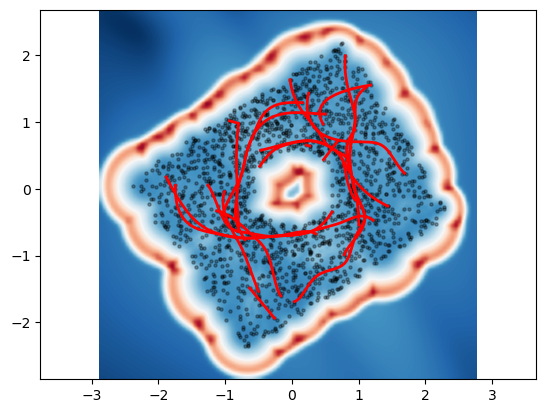

In [15]:
z1min, z2min = MU_Z_data.min(0) - 0.5
z1max, z2max = MU_Z_data.max(0) + 0.5
plt.figure()
utils.plot_measure(manifold_latent, np.linspace(z1min, z1max, 100), np.linspace(z2min, z2max, 100))
utils.my_plot(MU_Z_data, c='k', s=5, alpha=0.3)

# Compute some random curves using a heuristic graph solver
GRAPH_DATA = KMeans(n_clusters=100, n_init=30, max_iter=1000).fit(MU_Z_data).cluster_centers_
solver_graph = geodesics.SolverGraph(manifold_latent, data=GRAPH_DATA, kNN_num=5, tol=1e-2)
for _ in range(20):
    ind_0, ind_1 = np.random.choice(N_train, 2, replace=False)
    c0 = MU_Z_data[ind_0, :].reshape(-1, 1)
    c1 = MU_Z_data[ind_1, :].reshape(-1, 1)

    curve_graph, logmap_graph, curve_length_graph, failed_graph, solution_graph \
        = geodesics.compute_geodesic(solver_graph, manifold_latent, c0, c1)
    geodesics.plot_curve(curve_graph, c='r', linewidth=2)

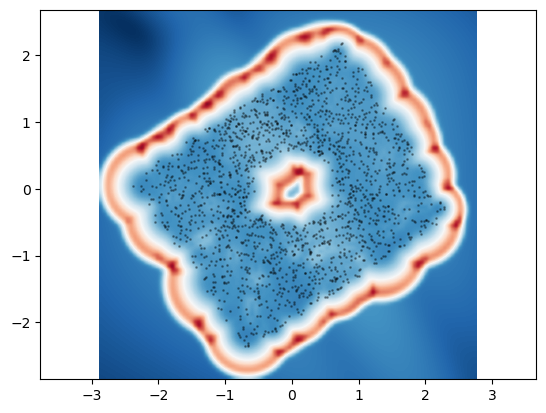

In [17]:
z1min, z2min = MU_Z_data.min(0) - 0.5
z1max, z2max = MU_Z_data.max(0) + 0.5
plt.figure()
utils.plot_measure(manifold_latent, np.linspace(z1min, z1max, 100), np.linspace(z2min, z2max, 100))
utils.my_plot(MU_Z_data, c='k', s=1, alpha=0.3)